# Effective Connectivity Estimated With (Deep) Echo State Networks 

Initially we try the method with artificially generated data to uncover causal relationships. Once we are sure that the Echo State Network is able to learn trivial causal relationships, we train it with real fMRI time series.

In [1]:
import numpy as np
import matplotlib.pylab as plt
from pyrcn.base.blocks import InputToNode, NodeToNode
from pyrcn.echo_state_network import ESNRegressor

from utils.training_utils import *
from utils.RCC_utils import *
from utils.plotting_utils import plot_RCC_input2output
from utils.reservoir_networks import *

### Unidirectional causal relationship

- $x(t+1) = x(t) \left[ 3.78 - 3.78 x(t) \right]$
- $y(t+1) = y(t) \left[ 3.77 - 3.77 y(t) + C_{\tau_d}x(t-\tau_d) \right]$ 

where $\tau_d$ is the time lag and $C_{\tau_d}$ is the causal coupling.

In [3]:
N_points, t_lag, coupling = 7000, 10, -0.8
time_points = range(0, N_points)
x, y = [], []
x0, y0 = 0.1, 0.2
x.append(x0), y.append(y0)

for i in range(1, N_points):
    xi = x[i-1]*(3.78-3.78*x[i-1])
    yi = y[i-1]*(3.77-3.77*y[i-1])
    if i >= t_lag:
        yi += coupling*y[i-1]*x[i-t_lag]
    xi, yi = round(xi, 10), round(yi,10)
    x.append(xi), y.append(yi)
x, y = np.array(x), np.array(y)

In [29]:
#### Input to Node object (see PyRCN docs for info about the meanings) ####
I2N_config = { 
    "layer_size": 50,
    "sparsity": 0.3,
    "activation": "tanh",
    "scaling": 1,
    "shift": 0,
    "bias_scaling": 1,
    "bias_shift": 0,
    "random_seed": None #42
}

#### Node to Node object (see PyRCN docs for info about the meanings) ####
N2N_config = {
    "layer_size": 50,
    "sparsity": 1,
    "activation": "logistic",
    "spectral_radius": 1,
    "leakage": 1,
    "bidirectional": False,
    "random_seed": None #42
}

# We define the reservoir architecture
I2N_Vanilla = Vanilla_input2node(I2N_config)
N2N_Vanilla = Vanilla_node2node(N2N_config)

In [5]:
# Lags to test
lags = np.arange(-30,31)
# For statistics (Note: they are not really super important in the absence of noise)
runs = 1
correlations_x2y, correlations_y2x, results_x2y, results_y2x = RCC_statistics(x, y, lags, runs, I2N_Vanilla, N2N_Vanilla, split=75, skip=20)

# Statistics
mean_x2y, sem_x2y = np.mean(correlations_x2y, axis=0), np.std(correlations_x2y, axis=0)/np.sqrt(runs)
mean_y2x, sem_y2x = np.mean(correlations_y2x, axis=0), np.std(correlations_y2x, axis=0)/np.sqrt(runs)

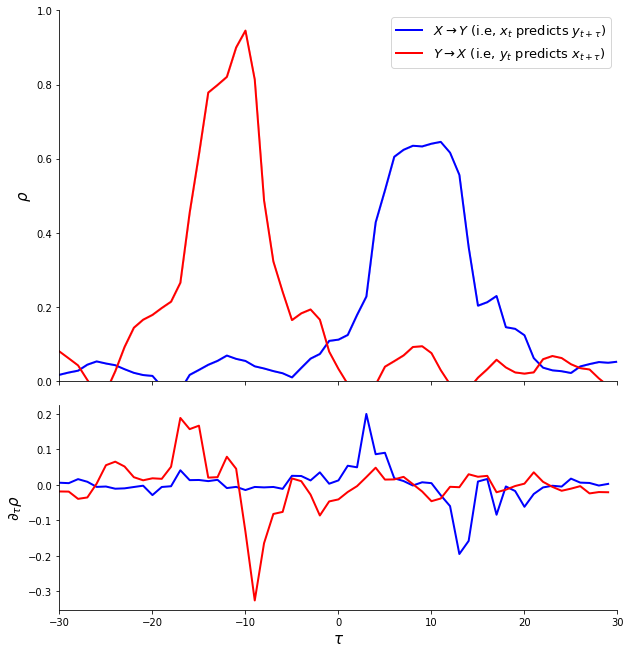

In [6]:
# Plot Causality
plot_RCC_input2output(lags, mean_x2y, mean_y2x, error_i2o=sem_x2y, error_o2i=sem_y2x)

### Bidirectional causal relationship 
- $x(t+1) = x(t) \left[ 3.78 - 3.78 x(t) + C^{y\rightarrow x}_{\tau_d}y(t-\tau^{y\rightarrow x}_d) \right]$
- $y(t+1) = y(t) \left[ 3.77 - 3.77 y(t) + C^{x\rightarrow y}_{\tau_d}x(t-\tau^{x\rightarrow y}_d) \right]$

Although the causal relationships are a bit more complex, the same Reserervoir Network achieves identical results to more sophisticated architectures. For weaker couplings we start to see effects (not clear yet) on the ability to disentangle causal relationships, although the number of neurons remain to be the most sensitive parameter. The effect of the number of neurons as well as the topology of the recurrent weights in the reservoir might also be important, but has previously been studied (Huang, et al. 2020). Here we build on that by adding modularity to the reservoir architecture.

An interesting case arises when $C^{y\rightarrow x}_{\tau_d} = -0.82$ and $C^{x\rightarrow y}_{\tau_d}=-0.02$, that is, when one causal direction is very clear while not the other. 

It's also interesting to see that the width of the peaks seem to be inversely proportional to the strength of the coupling.

In [98]:
N_points = 7000 
t_lag_x2y, coupling_x2y = 2, -0.02
t_lag_y2x, coupling_y2x = 8, -0.82

time_points = range(0, N_points)
x, y = [], []
x0, y0 = 0.1, 0.2
x.append(x0), y.append(y0)

for i in range(1, N_points):
    xi = x[i-1]*(3.78-3.78*x[i-1])
    yi = y[i-1]*(3.77-3.77*y[i-1])
    if i >= t_lag_y2x:
        xi += coupling_y2x * x[i-1] * y[i-t_lag_y2x]
    if i >= t_lag_x2y:
        yi += coupling_x2y * y[i-1] * x[i-t_lag_x2y]
    xi, yi = round(xi, 10), round(yi,10)
    x.append(xi), y.append(yi)
x, y = np.array(x), np.array(y)

In [103]:
#### Input to Node object (see PyRCN docs for info about the meanings) ####
I2N_config = { 
    "layer_size": 200,
    "sparsity": 0.3,
    "activation": "tanh",
    "scaling": 1,
    "shift": 0,
    "bias_scaling": 1,
    "bias_shift": 0,
    "random_seed": None #42
}

#### Node to Node object (see PyRCN docs for info about the meanings) ####
N2N_config = {
    "layer_size": 200,
    "sparsity": 1,
    "activation": "logistic",
    "spectral_radius": 1,
    "leakage": 1,
    "bidirectional": False,
    "random_seed": None #42
}

######
### Defining vanilla input2node and node2node blocks ###
I2N_Vanilla = Vanilla_input2node(I2N_config)
N2N_Vanilla = Vanilla_node2node(N2N_config)

######
### Defining a sequential vanilla input2node --> node2node pipeline ###
I2N_sequential = Sequential_block(I2N_config, N2N_config)

######
### Defining parallel blocks of sequential vanilla input2node --> node2node pipelines### 
blocks = 3
I2N_parallel = Parallel_block(I2N_config, N2N_config, blocks=blocks)
#   The node2node block remains the same

#   Defining the concatenation node2node block 
N2N_concat_config = {
    "layer_size": blocks * N2N_config['layer_size'],
    "sparsity": 1,
    "activation": "logistic",
    "spectral_radius": 1,
    "leakage": 1,
    "bidirectional": False,
    "random_seed": None #42
}
N2N_parallel = Vanilla_node2node(N2N_concat_config)

In [108]:
# Lags to test
lags = np.arange(-30,31)
# For statistics (Note: they are not really super important in the absence of noise)
runs = 1
correlations_x2y, correlations_y2x, results_x2y, results_y2x = RCC_statistics(x, y, lags, runs, I2N_Vanilla, N2N_Vanilla, split=75, skip=20)

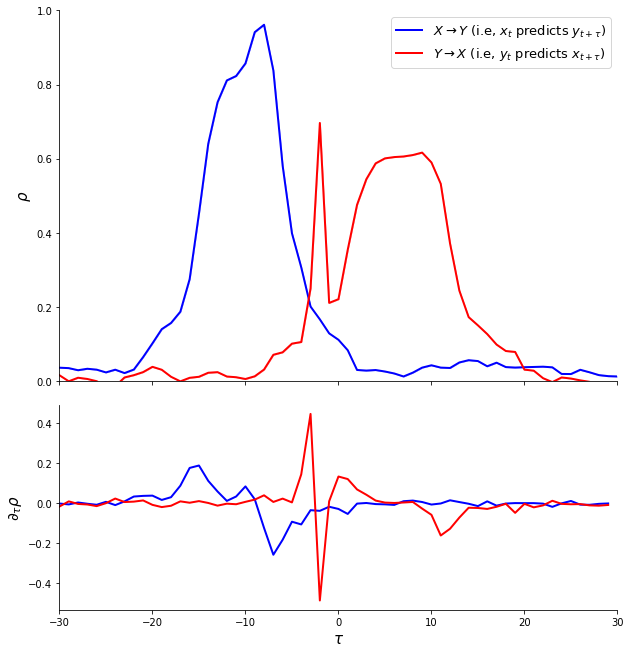

In [107]:
# Statistics
mean_x2y, sem_x2y = np.mean(correlations_x2y, axis=0), np.std(correlations_x2y, axis=0)/np.sqrt(runs)
mean_y2x, sem_y2x = np.mean(correlations_y2x, axis=0), np.std(correlations_y2x, axis=0)/np.sqrt(runs)

# Plot Causality
plot_RCC_input2output(lags, mean_x2y, mean_y2x, error_i2o=sem_x2y, error_o2i=sem_y2x)

### Bidirectional multiple causal relationships
- $x(t+1) = x(t) \left[ 3.78 - 3.78 x(t) + C^{y\rightarrow x}_{\tau_{d_1}}y(t-\tau^{y\rightarrow x}_{d_1}) + C^{y\rightarrow x}_{\tau_{d_2}}y(t-\tau^{y\rightarrow x}_{d_2}) + C^{y\rightarrow x}_{\tau_{d_3}}y(t-\tau^{y\rightarrow x}_{d_3}) + ... \right]$
- $y(t+1) = y(t) \left[ 3.77 - 3.77 y(t) + C^{x\rightarrow y}_{\tau_{d_1}}x(t-\tau^{x\rightarrow y}_{d_1}) + C^{x\rightarrow y}_{\tau_{d_2}}x(t-\tau^{x\rightarrow y}_{d_2}) + C^{x\rightarrow y}_{\tau_{d_3}}x(t-\tau^{x\rightarrow y}_{d_3}) + ... \right]$

Here the complexity of the causal relationships is considerably increased, hence the room for exploring parameters and architectures. 

##### If one of the causal couplings is way stronger than the other:
It seems that nothing we do is able to distinguish all the relationships. It seems that the Vanilla Reservoir is not really able to disentangle the 4 causal relationships (only 2 of them), not even when drastically incrementing the number of neurons (e.g., $\sim 1000$). Also increasing the modularity of the architecture achieves no improvement.

##### If all causal couplings are more or less simialar:
Once again the number of neurons is the best parameter to play with. The higher the number the better the reservoir is able to disentangle al causal relationships.

In [16]:
N_points = 7000 
# x --> y
t_lag_x2y_1, coupling_x2y_1 = 3, -0.01
t_lag_x2y_2, coupling_x2y_2 = 10, -0.02
# y --> x
t_lag_y2x_1, coupling_y2x_1 = 2, -0.04
t_lag_y2x_2, coupling_y2x_2 = 7, -0.02

time_points = range(0, N_points)
x, y = [], []
x0, y0 = 0.1, 0.2
x.append(x0), y.append(y0)

for i in range(1, N_points):
    xi = x[i-1]*(3.78-3.78*x[i-1])
    yi = y[i-1]*(3.77-3.77*y[i-1])

    # y --> x
    if i >= t_lag_y2x_1:
        xi += coupling_y2x_1 * x[i-1] * y[i-t_lag_y2x_1]
    if i >= t_lag_y2x_2:
        xi += coupling_y2x_2 * x[i-1] * y[i-t_lag_y2x_2]

    # x --> y
    if i >= t_lag_x2y_1:
        yi += coupling_x2y_1 * y[i-1] * x[i-t_lag_x2y_1]
    if i >= t_lag_x2y_2:
        yi += coupling_x2y_2 * y[i-1] * x[i-t_lag_x2y_2]
        
    xi, yi = round(xi, 10), round(yi,10)
    x.append(xi), y.append(yi)
x, y = np.array(x), np.array(y)

In [27]:
#### Input to Node object (see PyRCN docs for info about the meanings) ####
I2N_config = { 
    "layer_size": 400,
    "sparsity": 0.3,
    "activation": "tanh",
    "scaling": 1,
    "shift": 0,
    "bias_scaling": 1,
    "bias_shift": 0,
    "random_seed": None #42
}

#### Node to Node object (see PyRCN docs for info about the meanings) ####
N2N_config = {
    "layer_size": 400,
    "sparsity": 1,
    "activation": "logistic",
    "spectral_radius": 1,
    "leakage": 1,
    "bidirectional": False,
    "random_seed": None #42
}

######
### Defining vanilla input2node and node2node blocks ###
I2N_Vanilla = Vanilla_input2node(I2N_config)
N2N_Vanilla = Vanilla_node2node(N2N_config)

######
### Defining a sequential vanilla input2node --> node2node pipeline ###
s_blocks = 3
I2N_sequential = Sequential_block(I2N_config, N2N_config, blocks=s_blocks)

######
### Defining parallel blocks of sequential vanilla input2node --> node2node pipelines### 
p_blocks = 10
I2N_parallel = Parallel_block(I2N_config, N2N_config, blocks=p_blocks)
#   The node2node block remains the same

#   Defining the concatenation node2node block 
N2N_concat_config = {
    "layer_size": p_blocks * N2N_config['layer_size'],
    "sparsity": 1,
    "activation": "logistic",
    "spectral_radius": 1,
    "leakage": 1,
    "bidirectional": False,
    "random_seed": None #42
}
N2N_parallel = Vanilla_node2node(N2N_concat_config)

In [28]:
# Lags to test
lags = np.arange(-30,31)
# For statistics (Note: they are not really super important in the absence of noise)
runs = 1
# Compute RCC causality
correlations_x2y, correlations_y2x, results_x2y, results_y2x = RCC_statistics(x, y, lags, runs, I2N_Vanilla, N2N_Vanilla, split=75, skip=20)

# Statistics
mean_x2y, sem_x2y = np.mean(correlations_x2y, axis=0), np.std(correlations_x2y, axis=0)/np.sqrt(runs)
mean_y2x, sem_y2x = np.mean(correlations_y2x, axis=0), np.std(correlations_y2x, axis=0)/np.sqrt(runs)

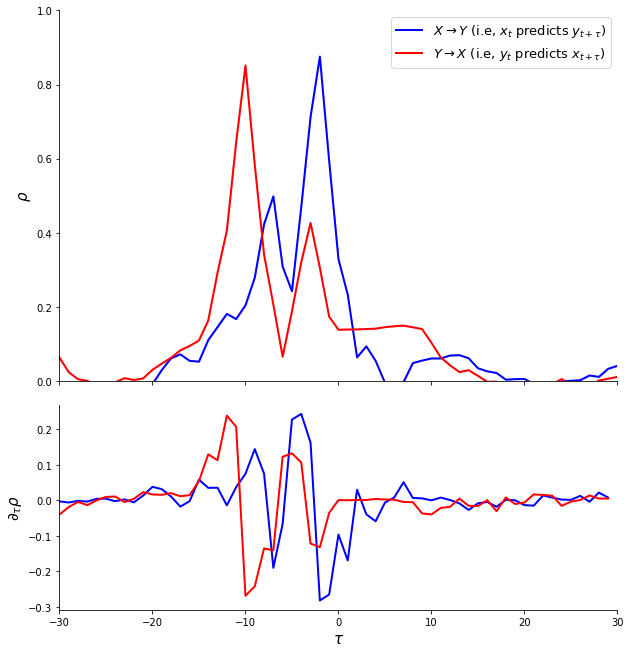

In [30]:
# Plot Causality
plot_RCC_input2output(lags, mean_x2y, mean_y2x, error_i2o=sem_x2y, error_o2i=sem_y2x)